In [80]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("magma")

params = {
    'legend.fontsize': '15',
    'figure.figsize': (15, 8),
     'axes.labelsize': '20',
     'axes.titlesize':'30',
     'xtick.labelsize':'18',
     'ytick.labelsize':'18',
}
plt.rcParams.update(params)

In [57]:
import warnings
warnings.filterwarnings("ignore")

In [58]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks

In [59]:
def plotDf(df, layOut=(4,4)):
    df.plot(kind='line', subplots=True, layout=layOut, figsize=(22,50))
    plt.show()
    
def normalize(a):
    return (a-a.min())/(a.max()-a.min())

In [60]:
df = pd.read_csv("books.csv", error_bad_lines = False)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


In [61]:
df.columns = ['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher']

In [295]:
df.head(2)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publication_year,publication_month,publication_day
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,2006,16,9
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,2004,1,9


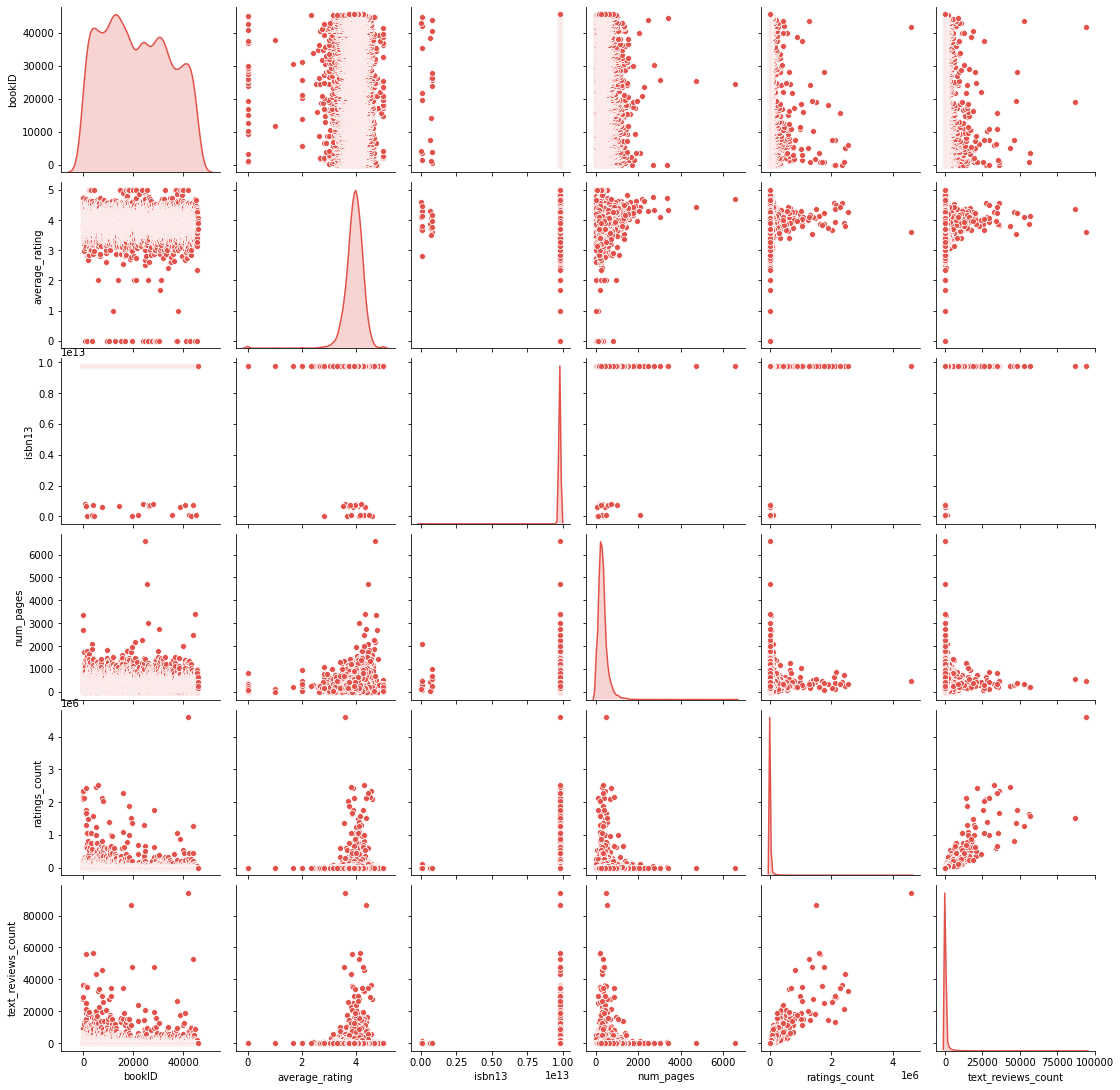

In [68]:
sns.pairplot(df, diag_kind='kde')

# Average Book Rating

<AxesSubplot:ylabel='Frequency'>

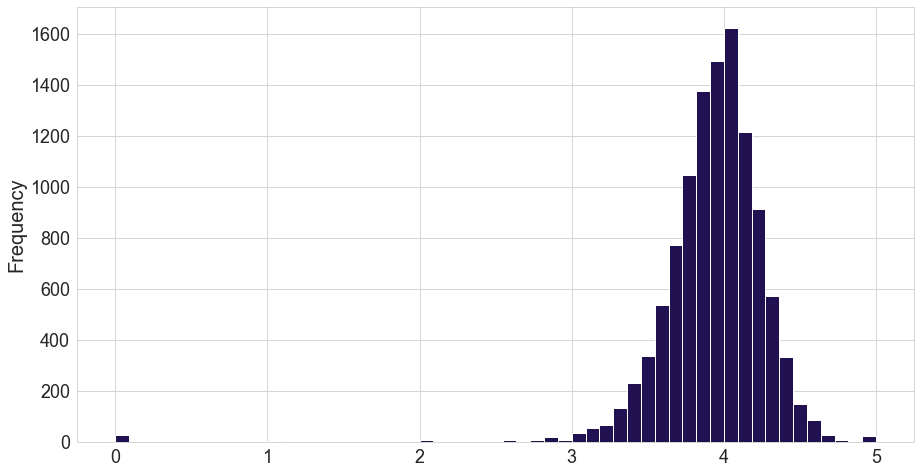

In [109]:
df["average_rating"].plot(kind="hist", bins=55)

In [94]:
rating = df["average_rating"]

<AxesSubplot:ylabel='Frequency'>

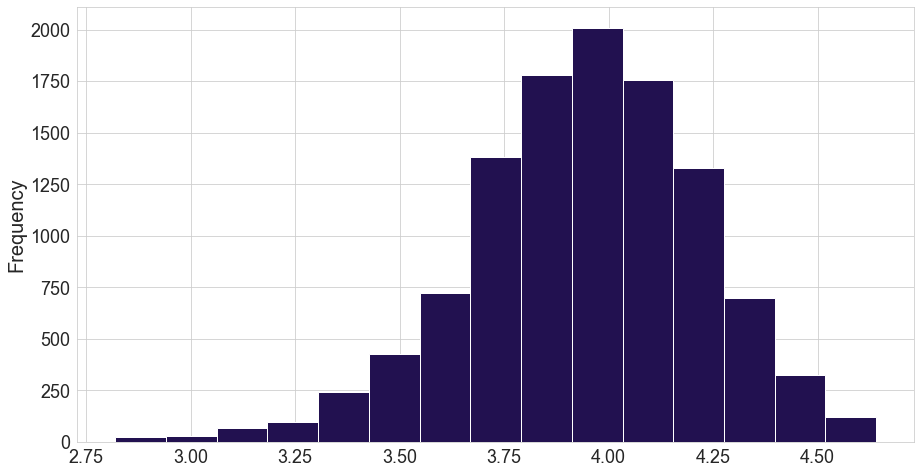

In [363]:
rating99 = rating[rating.between(rating.quantile(.005), rating.quantile(.995))]
rating99.plot(kind="hist", bins=15)

In [104]:
dfrating = df[rating.between(rating.quantile(.01), rating.quantile(.99))]

In [108]:
len(dfrating)-len(df),len(dfrating)/len(df)

(-215, 0.9806706823698642)

# Language Code

<AxesSubplot:>

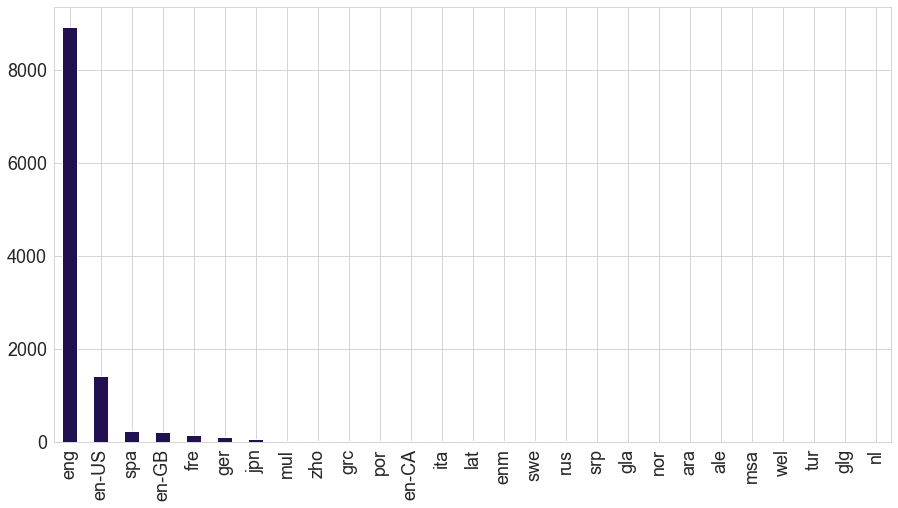

In [114]:
df["language_code"].value_counts().plot(kind="bar")

In [117]:
df["language_code"].str.contains('eng')

0         True
1         True
2         True
3         True
4         True
         ...  
11118     True
11119     True
11120     True
11121     True
11122    False
Name: language_code, Length: 11123, dtype: bool

In [121]:
len(df[df["language_code"]=="eng"])-len(df)

-2215

In [127]:
endf = df[df["language_code"].str.contains("eng|en-")]

In [128]:
len(endf)-len(df), len(endf)/len(df)

(-586, 0.9473163714825137)

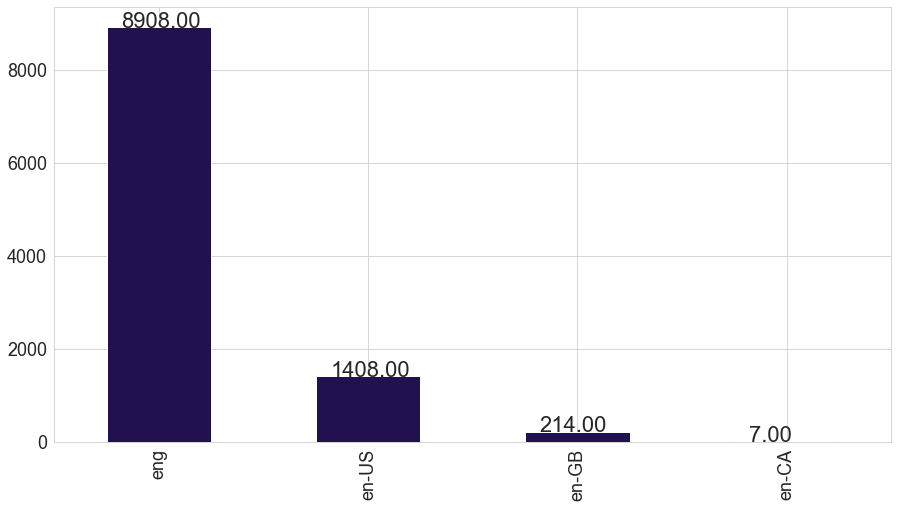

In [149]:
ax = endf["language_code"].value_counts().plot(kind="bar")
x_offset = -0.18
y_offset = 0.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset), fontsize=22)

# Book Page Count

In [63]:
df[["title", "num_pages"]].sort_values("num_pages")

,title,num_pages
2765,The Far Pavilions,0
2448,The Complete Science Fiction Treasury of H.G. ...,0
8989,First King of Shannara (Shannara Prequel),0
8953,13th Directorate,0
2676,Blind Willow Sleeping Woman: 24 Stories,0
...,...,...
6822,Summa Theologica 5 Vols,3020
6,Harry Potter Collection (Harry Potter #1-6),3342
10906,Remembrance of Things Past (Boxed Set),3400
6802,The Second World War,4736


<AxesSubplot:ylabel='Frequency'>

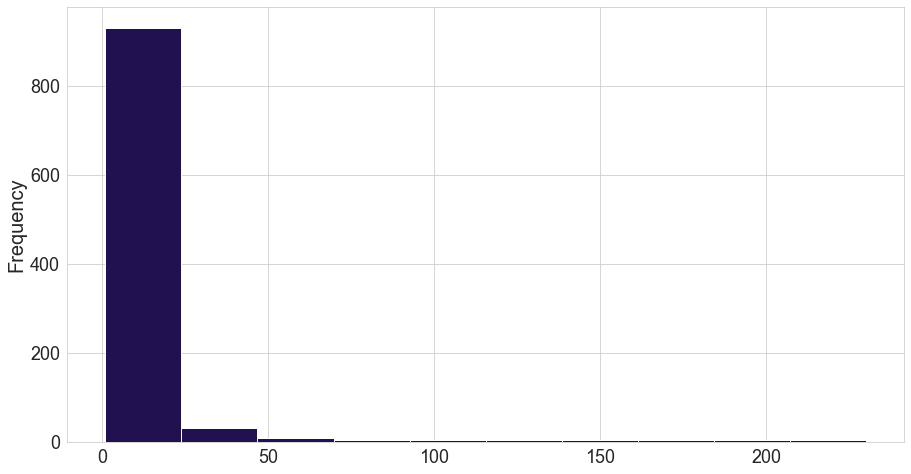

In [223]:
df["num_pages"].value_counts().plot(kind="hist", bins=10)

(0.0, 2001.0)

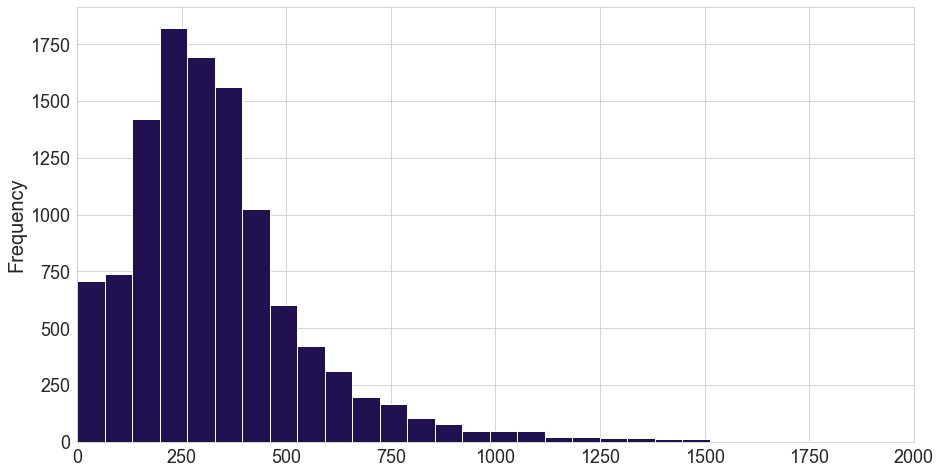

In [82]:
ax = df["num_pages"].plot(kind="hist", bins=100)
ax.set_xlim([0, 2001])
# ax.set_ylim([0, 5])

In [44]:
df[df["num_pages"] > 2000]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
6,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic
1053,3579,The Complete Anne of Green Gables Boxed Set (A...,L.M. Montgomery,4.43,0553609416,76783609419,eng,2088,98611,1447,10/6/1998,Starfire
5614,20749,Study Bible: NIV,Anonymous,4.70,0310929555,9780310929550,eng,2198,4166,186,10/1/2002,Zondervan Publishing House
6257,23589,The J.R.R. Tolkien Companion and Guide,Christina Scull/Wayne G. Hammond,4.64,0618391134,9780618391134,eng,2264,45,0,11/2/2006,Houghton Mifflin Harcourt
6497,24520,The Complete Aubrey/Maturin Novels (5 Volumes),Patrick O'Brian,4.70,039306011X,9780393060119,eng,6576,1338,81,10/17/2004,W. W. Norton Company
6802,25587,The Second World War,Winston S. Churchill/John Keegan,4.45,039541685X,9780395416853,eng,4736,1493,99,5/9/1986,Mariner Books
6822,25709,Summa Theologica 5 Vols,Thomas Aquinas,4.12,0870610635,9780870610639,eng,3020,2734,84,1/1/1981,Christian Classics
7862,30258,Harrison's Principles of Internal Medicine,Dennis L. Kasper/Dan L. Longo/Stephen L. Hause...,4.35,0071391401,9780071391405,eng,2751,23,4,7/27/2004,McGraw-Hill Medical Publishing
9929,40012,Goodman & Gilman's the Pharmacological Basis o...,Laurence L. Brunton/John S. Lazo/Keith L. Parker,4.29,0071422803,9780071422802,eng,2021,185,8,9/21/2005,McGraw-Hill Professional Publishing


# Ratings Count

<AxesSubplot:>

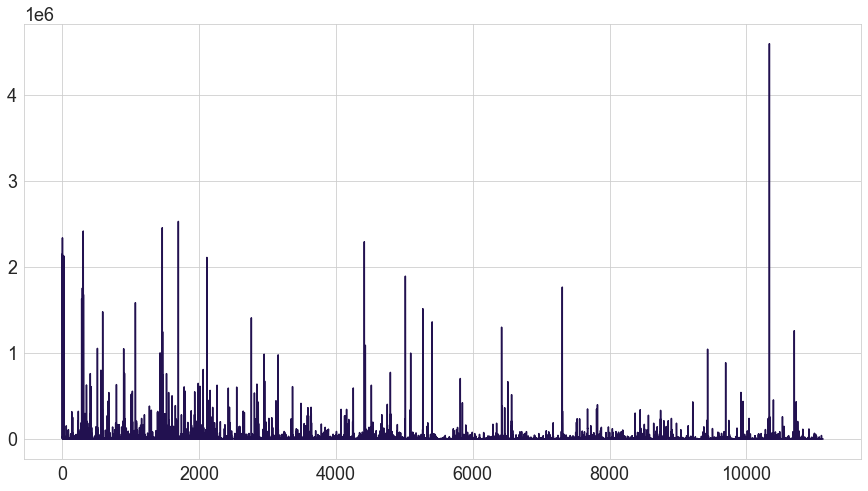

In [150]:
df["ratings_count"].plot()

In [188]:
ratecountdf = df[["ratings_count"]]
ratecountdf = ratecountdf[ratecountdf["ratings_count"] > 100]
ratecountdf.sort_values("ratings_count", ascending=False)

,ratings_count
10336,4597666
1697,2530894
1462,2457092
307,2418736
3,2339585
...,...
4392,101
9738,101
6897,101
10018,101


<AxesSubplot:>

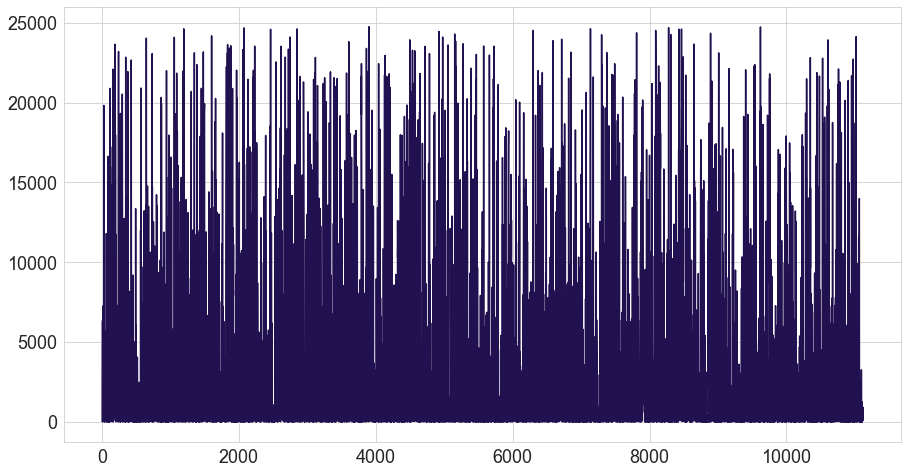

In [217]:
ratingcount = df["ratings_count"]
ratingc = ratingcount[ratingcount.between(rating.quantile(.1), ratingcount.quantile(.9))]
ratingc.plot()

In [209]:
ratingc.min()

0

In [200]:
len(ratingc)/len(df)

0.9621504989661063

<AxesSubplot:>

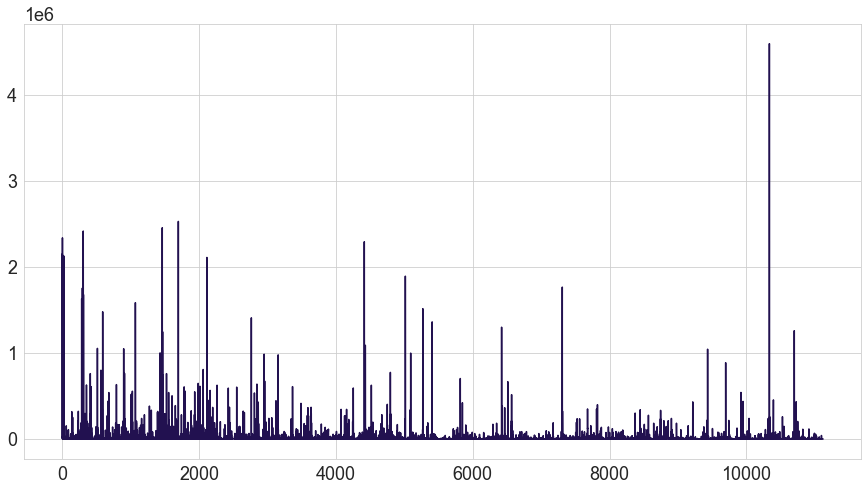

In [216]:
df[df["ratings_count"] != 0]["ratings_count"].plot()

# Text Reviews Count

<AxesSubplot:>

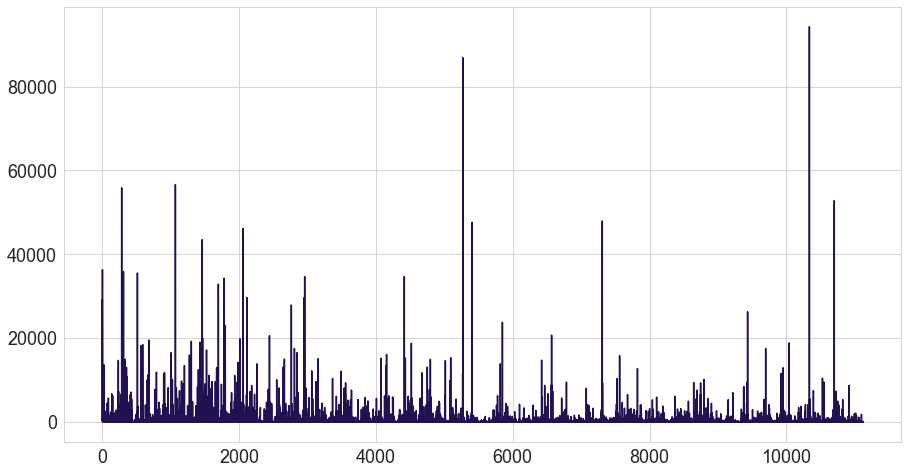

In [211]:
df["text_reviews_count"].plot()

In [ ]:
# Publication Date

In [291]:
df["publication_date"][0].split("/")[2]

'2006'

In [310]:
df["publication_year"] = df["publication_date"].apply(lambda x: int(x.split("/")[2]))
df["publication_day"] = df["publication_date"].apply(lambda x: int(x.split("/")[1]))
df["publication_month"] = df["publication_date"].apply(lambda x: int(x.split("/")[0]))

<AxesSubplot:>

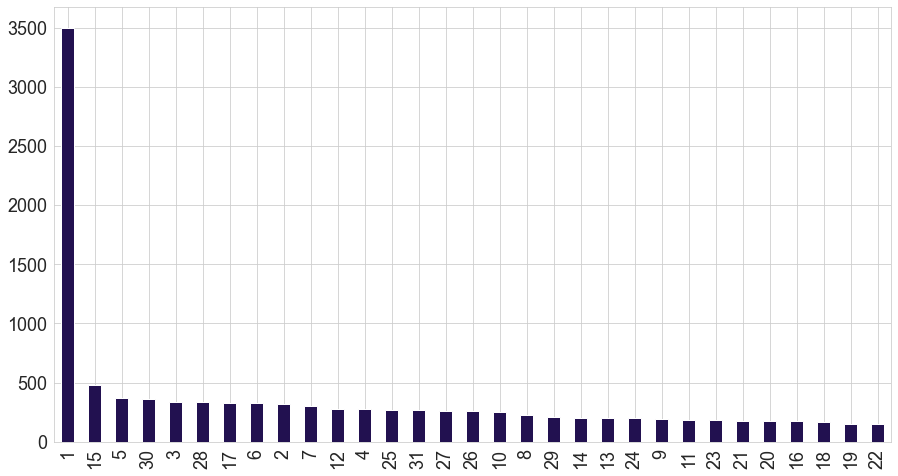

In [314]:
df["publication_day"].value_counts().plot(kind="bar")

<AxesSubplot:>

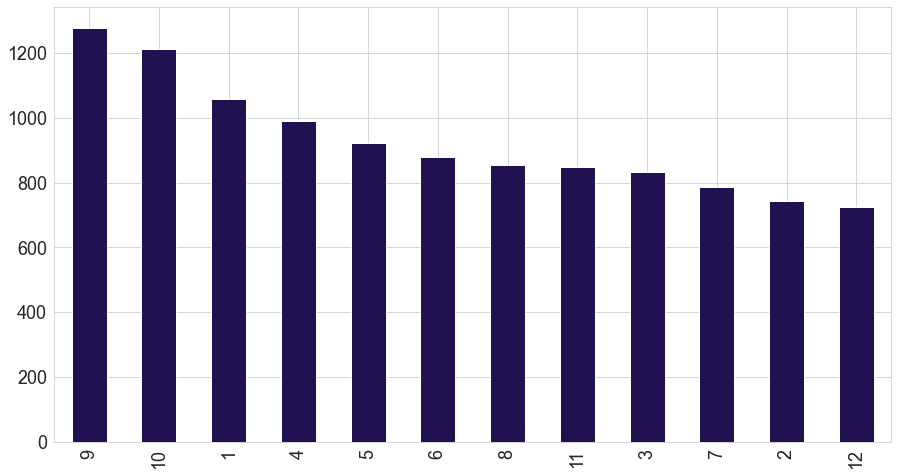

In [312]:
df["publication_month"].value_counts().plot(kind="bar")

In [356]:
str(df["publication_year"].value_counts(bins=10).index[0])

'(1996.0, 2008.0]'

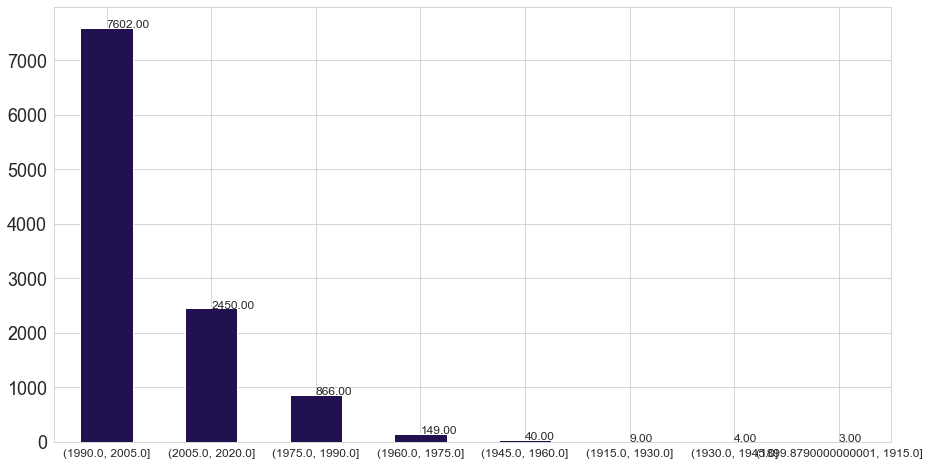

In [362]:
ax = df["publication_year"].value_counts(bins=8).plot(kind="bar", rot=0)
ax.set_xticklabels(df["publication_year"].value_counts(bins=8).index, fontsize=12)
x_offset = 0.0
y_offset = 0.02
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset), fontsize=12)

In [340]:
df["publication_year"].value_counts(bins=10)

(1996.0, 2008.0]                8651
(1984.0, 1996.0]                1752
(1972.0, 1984.0]                 376
(2008.0, 2020.0]                 183
(1960.0, 1972.0]                 105
(1948.0, 1960.0]                  38
(1912.0, 1924.0]                   7
(1924.0, 1936.0]                   6
(1936.0, 1948.0]                   4
(1899.8790000000001, 1912.0]       1
Name: publication_year, dtype: int64

In [339]:
df["publication_year"].value_counts(bins=10).round()

(1996.0, 2008.0]                8651
(1984.0, 1996.0]                1752
(1972.0, 1984.0]                 376
(2008.0, 2020.0]                 183
(1960.0, 1972.0]                 105
(1948.0, 1960.0]                  38
(1912.0, 1924.0]                   7
(1924.0, 1936.0]                   6
(1936.0, 1948.0]                   4
(1899.8790000000001, 1912.0]       1
Name: publication_year, dtype: int64

In [324]:
df[df["publication_year"] == 2020]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,publication_year,publication_month,publication_day
9664,38568,A Quick Bite (Argeneau #1),Lynsay Sands,3.91,0060773758,9780060773755,eng,360,35275,1370,3/31/2020,Avon,2020,3,31


# Publisher

<AxesSubplot:>

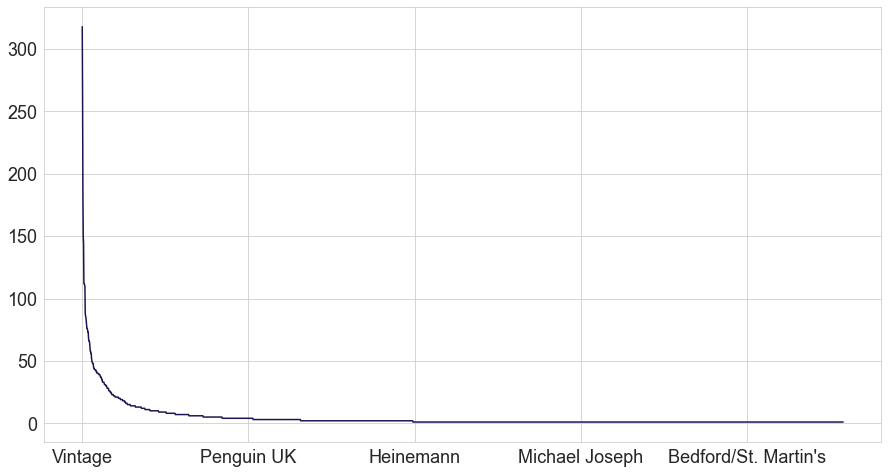

In [232]:
df["publisher"].value_counts().plot()

In [276]:
vc = df["publisher"].value_counts()
vc2 = vc[vc > 1]
df[df["publisher"].isin(list(pd.DataFrame(vc2).T.columns))]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
...,...,...,...,...,...,...,...,...,...,...,...,...
11118,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press
11119,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books
11120,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books
11121,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco


In [287]:
df[df["publisher"].str.contains("Penguin")]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
89,151,Anna Karenina,Leo Tolstoy/Richard Pevear/Larissa Volokhonsky,4.05,0143035002,9780143035008,eng,838,16643,1851,5/31/2004,Penguin Classics
91,153,Anna Karenina,Leo Tolstoy/Richard Pevear/Larissa Volokhonsky...,4.05,0140449175,9780140449174,eng,837,2904,309,1/30/2003,Penguin Books
98,162,Untouchable,Mulk Raj Anand/E.M. Forster,3.71,0140183957,9780140183955,eng,160,3429,279,7/3/1990,Penguin Books
128,264,The Portrait of a Lady,Henry James/Patricia Crick,3.78,0141439637,9780141439631,eng,797,61640,1951,9/30/2003,Penguin Classics
135,289,The Beloved: Reflections on the Path of the Heart,Kahlil Gibran/John Walbridge/Robin Waterfield,4.19,014019553X,9780140195538,eng,102,328,16,1/1/1998,Penguin Books
...,...,...,...,...,...,...,...,...,...,...,...,...
11095,45533,Montaillou: Cathars and Catholics in a French ...,Emmanuel Le Roy Ladurie/Barbara Bray,3.96,0140054715,9780140054712,en-GB,400,17,2,5/29/1980,Penguin Books Ltd.
11096,45536,On the Road,Jack Kerouac/Ann Charters,3.63,0142437255,9780142437254,en-US,307,3271,342,1/3/2006,Penguin Classics
11117,45630,Whores for Gloria,William T. Vollmann,3.69,0140231579,9780140231571,en-US,160,932,111,2/1/1994,Penguin Books
11119,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books
